In [108]:
import pandas as pd

# TODO: update for state
STATE = 'pa'
YEARS = [str(yr) for yr in range(2016, 2020)]

In [109]:
"""
File naming convension for ACS 5-year downloads:
state_year_[race|income].csv

"""

def get_filepath(state):
    return '../data/{state}/'.format(state=state)

def get_fname(state, year, dataset_type):
    return '{state}_{year}_{dataset_type}.csv'.format(
        state=state, year=year, dataset_type=dataset_type)

def get_filename(state, year, dataset_type):
    return get_filepath(state) + get_fname(state, year, dataset_type)


# geoid is the column we join data on
geoid_column_name = 'geoid'

geoid_column_map = {
    'GEO.id2': geoid_column_name,
    'GEO_ID': geoid_column_name
}

# for some reason particular file(s) have different column names- WHY?!
filename_income_column_map = {
    'ma_2017_income.csv': {
        'HC03_EST_VC02': 'median income',
        'HC03_MOE_VC02': 'median income margin of error',
        'HD01_VD01': 'median income',
        'HD02_VD01': 'median income margin of error'
    }
}
# Here is the default
income_column_map = {
    'HC02_EST_VC02': 'median income',
    'HC02_MOE_VC02': 'median income margin of error',
    'HD01_VD01': 'median income',
    'HD02_VD01': 'median income margin of error'
}

new_income_map = {
    'S1903_C03_001E': 'median income',
    'S1903_C03_001M': 'median income margin of error'
}

new_income_map_early = {
    'S1903_C02_001E': 'median income',
    'S1903_C02_001M': 'median income margin of error'
}

race_column_map = {
    'HD01_VD01': 'race: total households',
    'HD02_VD01': 'race: total households margin of error',
    'HD01_VD02': 'race: White',
    'HD01_VD03': 'race: Black',
    'HD01_VD05': 'race: Asian',
    'HD01_VD08': 'race: 2 or more races',
    # The following are combined into one value
    # 'HD01_VD04': 'race: American Indian and Alaska',
    # 'HD01_VD06': 'race: Native Hawaiian and Other',
    'HD01_VD07': 'race: Other',
}

new_race_column_map = {
    'B02001_001E': 'race: total households',
    'B02001_001M': 'race: total households margin of error',
    'B02001_002E': 'race: White',
    'B02001_003E': 'race: Black',
    'B02001_005E': 'race: Asian',
    'B02001_008E': 'race: 2 or more races',
    'B02001_007E': 'race: Other'
}

def race_combine_other(row):
    
    """Combines the values for the other races with american indian, hawaiian, etc"""
    try:
        return int(row['HD01_VD04']) + int(row['HD01_VD06']) + int(row['HD01_VD07'])
    except:
        return int(row['B02001_004E']) + int(row['B02001_006E']) + int(row['B02001_007E'])

def col_name_for_year(year, col_name):
    return str(year) + ' ' + col_name

def remove_labels(df):
    # drop the first row (the first row is a display label)
    df.drop([0], inplace=True)

def preprocess_df(df, year, column_map):
    # prune data
    # data from 2018-onwards only has GEO_ID not GEO.id2
    # if int(year) >= 2017:
    #     for num in range(1, df.shape[0]+1):
    #         df.at[num, 'GEO_ID'] = df.at[num, 'GEO_ID'][-11:]
    for num in range(1, df.shape[0]+1):
        df.at[num, 'GEO_ID'] = df.at[num, 'GEO_ID'][-11:]  
    # rename columns
    column_name_map = {key: col_name_for_year(year, value) for key, value in column_map.items()}
    
    column_name_map.update(geoid_column_map)
    cols_to_drop = [col for col in df.columns if not col in column_name_map.keys()]

    df.drop(cols_to_drop,  axis=1,  inplace=True)
    df.rename(columns=column_name_map, inplace=True)
    df.set_index(geoid_column_name, inplace=True)
    return df


def get_race_df(state, year):
    filename = get_filename(STATE, year, 'race')
    df = pd.read_csv(filename)
    remove_labels(df)
    df['column'] = df.apply(race_combine_other, axis=1)
    if int(year) >= 2010:
        map = new_race_column_map
    else:
        map = race_column_map
    return preprocess_df(df, year, map)


def get_income_df(state, year):
    # so annoying that the columns change with files!
    if int(year) >= 2017:
        map = new_income_map
    else:
        map = new_income_map_early
    fname = get_fname(state, year, 'income')
    print('filename', fname)
    if fname in filename_income_column_map:
        map = filename_income_column_map[fname]
    df = pd.read_csv(get_filename(STATE, year, 'income'))
    print('income:df', df)
    remove_labels(df)
    return preprocess_df(df, year, map)


In [110]:
# We merge data into the income df

def add_df(df1, df2):
    # comebine the df's on geoid
    return pd.concat([df1, df2], axis=1, join='inner')

state_df = None
for year in YEARS:
    print('handling files for year ', year)
    income_df = get_income_df(STATE, year)
    if state_df is None:
        state_df = income_df
    else:
        state_df = add_df(state_df, income_df)
    # print(state_df)
    race_df = get_race_df(STATE, year)
    state_df = add_df(state_df, race_df)
# state_df = state_df.loc[state_df[geoid_column_name] == '48201410802']
state_df.head()



handling files for year  2016
filename pa_2016_income.csv
income:df                     GEO_ID                                             NAME  \
0                       id                             Geographic Area Name   
1     1400000US42001030101  Census Tract 301.01, Adams County, Pennsylvania   
2     1400000US42001030102  Census Tract 301.02, Adams County, Pennsylvania   
3     1400000US42001030200     Census Tract 302, Adams County, Pennsylvania   
4     1400000US42001030300     Census Tract 303, Adams County, Pennsylvania   
...                    ...                                              ...   
3214  1400000US42133023822   Census Tract 238.22, York County, Pennsylvania   
3215  1400000US42133023901   Census Tract 239.01, York County, Pennsylvania   
3216  1400000US42133023902   Census Tract 239.02, York County, Pennsylvania   
3217  1400000US42133024001   Census Tract 240.01, York County, Pennsylvania   
3218  1400000US42133024002   Census Tract 240.02, York County, 

,2016 median income,2016 median income margin of error,2016 race: total households,2016 race: total households margin of error,2016 race: White,2016 race: Black,2016 race: Asian,2016 race: Other,2016 race: 2 or more races,2017 median income,...,2018 race: 2 or more races,2019 median income,2019 median income margin of error,2019 race: total households,2019 race: total households margin of error,2019 race: White,2019 race: Black,2019 race: Asian,2019 race: Other,2019 race: 2 or more races
geoid,,,,,,,,,,,,,,,,,,,,,
42001030101,75489,6243,2587,16,2450,19,0,98,20,74976,...,86,79000,8065,2689,18,2441,35,0,96,117
42001030102,69750,3627,5813,27,5735,0,25,53,0,74051,...,86,82095,19042,5851,20,5740,20,0,0,91
42001030200,54368,2773,5309,226,4705,25,32,456,91,55409,...,44,58990,7322,5506,231,4862,44,51,517,22
42001030300,66250,6713,4229,163,3866,81,57,205,20,71375,...,46,76862,5821,4221,144,3955,60,36,133,37
42001030400,63920,6997,5857,180,5535,24,0,262,15,67500,...,7,70690,10077,5688,164,5295,21,125,246,1


In [111]:
# Save the giant dataframe to CSV
output_csvfilename = get_filepath(STATE) + 'race_and_income_data.csv'
state_df.to_csv(output_csvfilename)
print('saved data to ',  output_csvfilename)

saved data to  ../data/pa/race_and_income_data.csv


In [112]:
import geopandas as gpd

In [115]:
"""Creates shapefile from NYC open data download.
This shapefile does not have geoids, so must add them based on its other data.

"""

NY_STATE_CODE = '36'

nyc_shapefile_attributes = {
    geoid_column_name: geoid_column_name,
    'ntaname': 'Name', # name of neighborhood in this dataset
    # Tracts are duplicated across boros.
    # The unique key is 'boro_ct201' which is the concatenation of boro id and ct
    # 'ct2010': 'tract',
    'shape_area': 'shape_area',
    'shape_leng': 'shape_leng',
    'geometry': 'geometry'
}
ma_shapefile_attributes = {
    'GEOID10': geoid_column_name,
    'NAMELSAD10': 'Name', # 'Census Tract ###'  in this dataset
    'SHAPE_AREA': 'shape_area',
    'SHAPE_LEN': 'shape_leng',
    'geometry': 'geometry'
}

hou_shapefile_attributes = {
    'GEOID': geoid_column_name,
    'NAMELSAD': 'Name',
    'AREA': 'shape_area',
    'geometry': 'geometry'
}

# Mapping of boro names to county code for geoid
# Taken from wikipedia info: https://en.wikipedia.org/wiki/List_of_counties_in_New_York
nyc_boro_to_county_code = {
    'Bronx':'005',
    'Queens':'081',
    'Brooklyn':'047',
    'Manhattan':'061',
    'Staten Island':'085'
}


def get_nyc_shapefile():
    shapefile_filename = get_filepath('ny') + 'city_census_tracts_shapefile/geo_export_6f3df1e4-1be2-4395-ba6c-3e15b0a10221.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df[geoid_column_name] = shapefile_df.apply(get_nyc_geoid, axis=1)
    return shapefile_df


def get_nyc_county_code(row):
    boro_name = row['boro_name']
    return nyc_boro_to_county_code[boro_name]


def get_nyc_geoid(row):
    state_code = NY_STATE_CODE
    county_code = get_nyc_county_code(row)
    tract_code = row['ct2010']
    return str(state_code) + str(county_code) + str(tract_code)

shapefile_df = None
if STATE == 'ny':
    shapefile_df = get_nyc_shapefile()
    shapefile_attributes = nyc_shapefile_attributes
elif STATE == 'ma':
    shapefile_filename = get_filepath(STATE) + 'shapefile/boston-brookline-cambridge-somerville-everett.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_attributes = ma_shapefile_attributes
elif STATE == 'tx':
    shapefile_filename = get_filepath(STATE) + 'shapefiles/tl_2019_48_tract.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df = shapefile_df.loc[shapefile_df["COUNTYFP"] == '201']
    shapefile_df["AREA"] = shapefile_df["ALAND"].astype(int) + shapefile_df["AWATER"].astype(int)
    shapefile_attributes = hou_shapefile_attributes
elif STATE == 'dc':
    shapefile_filename = get_filepath(STATE) + 'shapefile/DC/tl_2019_11_tract.shp'
    dc_shapefile_df = gpd.read_file(shapefile_filename)

    shapefile_filename = get_filepath(STATE) + 'shapefile/MD/tl_2019_24_tract.shp'
    md_shapefile_df = gpd.read_file(shapefile_filename)
    md_shapefile_df1 = md_shapefile_df.loc[md_shapefile_df["COUNTYFP"] == '031']
    md_shapefile_df2 = md_shapefile_df.loc[md_shapefile_df["COUNTYFP"] == '033']
    md_shapefile_df = pd.concat([md_shapefile_df1, md_shapefile_df2], axis = 0)

    shapefile_filename = get_filepath(STATE) + 'shapefile/VA/tl_2019_51_tract.shp'
    va_shapefile_df = gpd.read_file(shapefile_filename)
    va_shapefile_df1 = va_shapefile_df.loc[va_shapefile_df["COUNTYFP"] == '013']
    va_shapefile_df2 = va_shapefile_df.loc[va_shapefile_df["COUNTYFP"] == '510']
    va_shapefile_df = pd.concat([va_shapefile_df1, va_shapefile_df2], axis = 0)

    shapefile_df = pd.concat([dc_shapefile_df, va_shapefile_df, md_shapefile_df], axis = 0)
    shapefile_df["AREA"] = shapefile_df["ALAND"].astype(int) + shapefile_df["AWATER"].astype(int)
    shapefile_attributes = hou_shapefile_attributes

elif STATE == 'il':
    shapefile_filename = get_filepath(STATE) + 'shapefile/tl_2019_17_tract.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df = shapefile_df.loc[shapefile_df["COUNTYFP"] == '031']
    shapefile_df["AREA"] = shapefile_df["ALAND"].astype(int) + shapefile_df["AWATER"].astype(int)
    shapefile_attributes = hou_shapefile_attributes

elif STATE == 'socal':
    shapefile_filename = get_filepath(STATE) + 'shapefiles/tl_2019_06_tract.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df = shapefile_df.loc[shapefile_df["COUNTYFP"] == '037']
    shapefile_df["AREA"] = shapefile_df["ALAND"].astype(int) + shapefile_df["AWATER"].astype(int)
    shapefile_attributes = hou_shapefile_attributes
elif STATE == 'pa':
    shapefile_filename = get_filepath(STATE) + 'shapefiles/tl_2019_42_tract.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df = shapefile_df.loc[shapefile_df["COUNTYFP"] == '101']
    shapefile_df["AREA"] = shapefile_df["ALAND"].astype(int) + shapefile_df["AWATER"].astype(int)
    shapefile_attributes = hou_shapefile_attributes

shapefile_df


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,AREA
60,42,101,989100,42101989100,9891,Census Tract 9891,G5020,S,2785522,1532456,+40.0360901,-075.0053457,"POLYGON ((-75.02251 40.03083, -75.02176 40.031...",4317978
70,42,101,001001,42101001001,10.01,Census Tract 10.01,G5020,S,229397,0,+39.9456722,-075.1516020,"POLYGON ((-75.15384 39.94256, -75.15383 39.942...",229397
71,42,101,000402,42101000402,4.02,Census Tract 4.02,G5020,S,303680,0,+39.9532973,-075.1686952,"POLYGON ((-75.17337 39.95256, -75.17336 39.952...",303680
76,42,101,036900,42101036900,369,Census Tract 369,G5020,S,1855495,193283,+39.9487238,-075.1937601,"POLYGON ((-75.20774 39.94137, -75.20751 39.941...",2048778
81,42,101,037300,42101037300,373,Census Tract 373,G5020,S,2587546,145214,+39.9024981,-075.1879361,"POLYGON ((-75.19399 39.90563, -75.19379 39.905...",2732760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,42,101,007102,42101007102,71.02,Census Tract 71.02,G5020,S,415761,0,+39.9409204,-075.2282511,"POLYGON ((-75.23363 39.94029, -75.23244 39.941...",415761
3001,42,101,008102,42101008102,81.02,Census Tract 81.02,G5020,S,362526,0,+39.9522216,-075.2345584,"POLYGON ((-75.23901 39.95095, -75.23891 39.951...",362526
3055,42,101,001002,42101001002,10.02,Census Tract 10.02,G5020,S,471654,0,+39.9450045,-075.1466193,"POLYGON ((-75.15065 39.94234, -75.15054 39.942...",471654
3144,42,101,030502,42101030502,305.02,Census Tract 305.02,G5020,S,699364,0,+40.0457205,-075.1046628,"POLYGON ((-75.11115 40.04219, -75.11104 40.042...",699364


In [116]:
# Map column names and remove columns
shapefile_cols_to_drop = [col for col in shapefile_df.columns if not col in shapefile_attributes.keys()]
shapefile_df.drop(shapefile_cols_to_drop,  axis=1,  inplace=True)
shapefile_df.rename(columns=shapefile_attributes, inplace=True)
shapefile_df.head()
shapefile_df.set_index(geoid_column_name, inplace=True)
shapefile_df.head() 



,Name,geometry,shape_area
geoid,,,
42101989100,Census Tract 9891,"POLYGON ((-75.02251 40.03083, -75.02176 40.031...",4317978
42101001001,Census Tract 10.01,"POLYGON ((-75.15384 39.94256, -75.15383 39.942...",229397
42101000402,Census Tract 4.02,"POLYGON ((-75.17337 39.95256, -75.17336 39.952...",303680
42101036900,Census Tract 369,"POLYGON ((-75.20774 39.94137, -75.20751 39.941...",2048778
42101037300,Census Tract 373,"POLYGON ((-75.19399 39.90563, -75.19379 39.905...",2732760


c:\Users\Walter\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

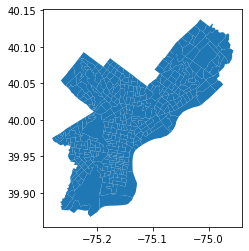

In [117]:
# Want projection CRS84 which is equivalent to EPSG:4326
shapefile_df = shapefile_df.to_crs({'init': 'epsg:4326'})

%matplotlib inline
shapefile_df.plot()

In [118]:
merged_shapes = shapefile_df.merge(state_df, on=geoid_column_name)
print('shape', merged_shapes.shape)
merged_shapes.head()

shape (384, 39)


,Name,geometry,shape_area,2016 median income,2016 median income margin of error,2016 race: total households,2016 race: total households margin of error,2016 race: White,2016 race: Black,2016 race: Asian,...,2018 race: 2 or more races,2019 median income,2019 median income margin of error,2019 race: total households,2019 race: total households margin of error,2019 race: White,2019 race: Black,2019 race: Asian,2019 race: Other,2019 race: 2 or more races
geoid,,,,,,,,,,,,,,,,,,,,,
42101989100,Census Tract 9891,"POLYGON ((-75.02251 40.03083, -75.02176 40.031...",4317978,-,**,2926,755,568,2085,47,...,70,-,**,1811,353,267,1343,16,35,103
42101001001,Census Tract 10.01,"POLYGON ((-75.15384 39.94256, -75.15382 39.942...",229397,87813,12884,2664,258,2296,64,124,...,93,106667,21075,2670,196,2455,67,83,11,44
42101000402,Census Tract 4.02,"POLYGON ((-75.17337 39.95256, -75.17336 39.952...",303680,70038,14655,3202,367,2721,178,249,...,100,78947,8808,4097,393,3356,214,434,0,93
42101036900,Census Tract 369,"POLYGON ((-75.20774 39.94137, -75.20751 39.941...",2048778,44464,18042,5355,903,3345,680,1099,...,268,28099,7852,5889,910,3376,842,1278,56,296
42101037300,Census Tract 373,"POLYGON ((-75.19399 39.90563, -75.19379 39.905...",2732760,78209,8490,5835,413,5088,226,460,...,10,82230,11567,5759,510,4684,584,422,0,10


In [119]:
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

In [120]:
to_filename = get_filepath(STATE) + STATE  + '_census_tracts.geojson'
print('saving to ',to_filename)
merged_shapes["geometry"] = [MultiPolygon([feature]) if type(feature) == Polygon \
    else feature for feature in merged_shapes["geometry"]]
merged_shapes.to_file(to_filename, driver='GeoJSON')
print('saved')
sort = False

saving to  ../data/pa/pa_census_tracts.geojson
saved
